In [1]:
from typing import Optional
import numpy as np
import csv
import pickle

class WalkSystem:
    
    """Create a walk system.
    
    Args:
        folder (str): refer to _folder_dict
        network (str): refer to _network_dict
        sys (str): refer to _sys_dict
        order (int): the order of a fractal network
        length (int): the length of a triangular network
        layers (int): the number of layers
        qw (bool): if the system is quantum walk or random walk
    """
    
    def __init__(self, 
                 folder: str, 
                 network: str, 
                 sys: Optional[str]=None, 
                 order: Optional[int]=None, 
                 length: Optional[int]=None, 
                 layers: Optional[int]=None, 
                 qw: bool=True,
                 logsize: bool=False,
                 **kwargs
                ):
                
        # Initialize
        self._qw = qw
        self._name = None
        
        # Save folder and network information according to dictionaries
        self._folder_dict = {'ex':'exact/', 'sim':'simulator/', 'qpu':'qpu/'}
        self._network_dict = {'tri':'tri', 'sg':'sg', 'dsg':'dsg'}
        self.folder = self._folder_dict[folder]
        self.network = self._network_dict[network]
        
        # Save sys or order or length, according to the exactness and the network
        self._sys_dict = {'qasm':'ibmq_qasm_simulator', 
                          'montreal':'ibmq_montreal', 'mumbai':'ibmq_mumbai', 'auckland':'ibm_auckland', 'hanoi':'ibm_hanoi', 
                          'ionq_sim':'ionq_simulator', 'ionq':'ionq_qpu'}
        if self.folder != 'exact/' and sys != None:
            self.sys = self._sys_dict[sys]
        elif self.network != 'tri' and order != None:
            self.sys = f'o{order}'
        elif self.network == 'tri' and length != None:
            self.sys = f'l{length}'
        else:
            self.sys = None
        
        # Save walk system according to exactness and boolean qw
        if self.folder == 'exact/' and self._qw:
            self.walk = 'exqw'
        elif self.folder == 'exact/' and not self._qw:
            self.walk = 'exrw'
        elif logsize:
            self.walk = 'log3tqw'
        else:
            self.walk = '3tqw'
        
        # If the system is exact, the number of simulating steps is fixed to 1500
        # If not, it is 300
        if self.folder == 'exact/':
            self._steps = 1500
        else:
            self._steps = 300
        
        # dt = .01
        self._dt = .01
        
        # Save layer information to be variational if the system is exact
        if self.folder == 'exact/':
            self._ly = '1500vly'
        elif layers != None:
            self._ly = f'{layers}ly'
        else:
            self._ly = None
        
        # Unpack kwags
        for key, value in kwargs.items():
            if key == 'name':
                self._name = value
        
    @property
    def name(self):
        if self._name == None:
            return f'{self.sys}_{self.network}_{self.walk}_{self._steps*self._dt:.1f}s_{self._ly}'
        else:
            return self._name
    
    @property
    def dict_list(self) -> list:
        """Return dictionary list.
        """
        return list[self._folder_dict, self._network_dict, self._sys_dict]
    
    def read_msd_list(self, **kwargs) -> np.ndarray:
        
        for key, value in kwargs.items():
            if key == 'sys' and self.folder != 'exact/':
                self.sys = self._sys_dict[value]
            elif key == 'order' and self.network != 'tri':
                self.sys = f'o{value}'
            elif key == 'length' and self.network == 'tri':
                self.sys = f'l{value}'
            elif key == 'layers' and self.folder != 'exact/':
                self._ly = f'{value}ly'
        
        if self.sys == None or self._ly == None:
            raise SyntaxError
        
        msd_list = []
        with open(f'{self.folder}{self.name}_msd_list.csv','r') as file :
            read = csv.reader(file)
            for row in read:
                for item in row:
                    msd_list.append(float(item))
        
        return np.array(msd_list)
    
    def read_counts_list(self, **kwargs):
        
        for key, value in kwargs.items():
            if key == 'sys' and self.folder != 'exact/':
                self.sys = self._sys_dict[value]
            elif key == 'order' and self.network != 'tri':
                self.sys = f'o{value}'
            elif key == 'length' and self.network == 'tri':
                self.sys = f'l{value}'
            elif key == 'layers' and self.folder != 'exact/':
                self._ly = f'{value}ly'
        
        if self.sys == None or self._ly == None:
            raise SyntaxError
        
        with open(f'{self.folder}{self.name}_counts_list.pkl','rb') as file :
            counts_list = pickle.load(file)
        
        return counts_list
    
    def read_all_msd(self, **kwargs) -> np.ndarray:
        
        msd_by_kwargs = []
        for key, arg_list in kwargs.items():
            for arg in arg_list:
                if key == 'sys':
                    msd_by_kwargs.append(self.read_msd_list(sys=arg))
                elif key == 'order':
                    msd_by_kwargs.append(self.read_msd_list(order=arg))
                elif key == 'length':
                    msd_by_kwargs.append(self.read_msd_list(length=arg))
                elif key == 'layers':
                    msd_by_kwargs.append(self.read_msd_list(layers=arg))
        
        return np.array(msd_by_kwargs)
    
    def read_all_counts(self, **kwargs):
        
        counts_by_kwargs = []
        for key, arg_list in kwargs.items():
            for arg in arg_list:
                if key == 'sys':
                    counts_by_kwargs.append(self.read_counts_list(sys=arg))
                elif key == 'order':
                    counts_by_kwargs.append(self.read_counts_list(order=arg))
                elif key == 'length':
                    counts_by_kwargs.append(self.read_counts_list(length=arg))
                elif key == 'layers':
                    counts_by_kwargs.append(self.read_counts_list(layers=arg))
        
        return counts_by_kwargs

In [2]:
import numpy as np

def fitting(t: np.ndarray, consts: list, powers: list, si=None, steps=None, linewidth=None, linestyle=None):
    
    fitting_line = []
    for const, power in zip(consts, powers):
        fitting_line.append(const*t**power)
    fitting_line = np.array(fitting_line)
    
    for i, (const, power) in enumerate(zip(consts, powers)):
        plt.plot(t[si:sf], fitting_line[i,si:sf], linewidth=linewidth, linestyle=linestyle, label=f'{const}*t^{power:.2f}')
    
    return 0

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
steps = 1500
dt = 0.01
t = np.linspace(dt, steps*dt, steps)

order_dict = {2:0, 3:1, 4:2}
length_dict = {3:0, 4:1, 7:2, 8:3, 15:4, 16:5}
layer_dict = {1:0, 2:1, 3:2, 4:3, 5:4, 10:5}

In [5]:
order = 2
length = 2**order-1

In [6]:
folder = 'ex'
network = 'dsg'
ws = WalkSystem(folder, network, order=order)
exact = ws.read_msd_list()

In [7]:
folder = 'ex'
network = 'tri'
ws = WalkSystem(folder, network, length=length)
tri = ws.read_msd_list()

In [8]:
folder = 'sim'
network = 'dsg'
sys = 'qasm'
layers = [1,2,3,4,5,10]
ws = WalkSystem(folder, network, sys=sys)
qasm = ws.read_all_msd(layers=layers)

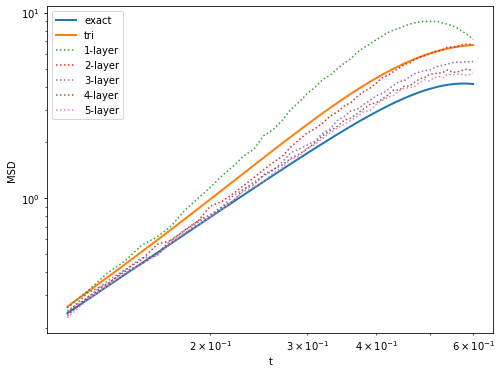

In [9]:
si = 10
sf = 60

fig = plt.figure(figsize=(8, 6))
linewidth = 2
linestyle = '-'
selected_layers = [1,2,3,4,5]

plt.plot(t[si:sf], exact[si:sf], linewidth=linewidth, linestyle=linestyle, label='exact')
plt.plot(t[si:sf], tri[si:sf], linewidth=linewidth, linestyle=linestyle, label='tri')
for ly in selected_layers:
    i = layer_dict[ly]
    plt.plot(t[si:sf], qasm[i, si:sf], linewidth=1.5, linestyle=':', label=f'{ly}-layer')

plt.legend()
plt.xlabel("t")
plt.ylabel("MSD")
plt.xscale("log")
plt.yscale("log")
plt.show()

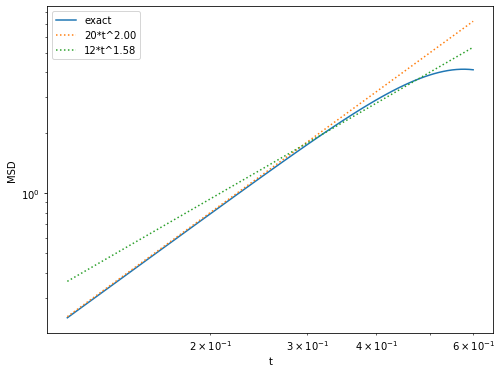

In [10]:
si = 10
sf = 60

fig = plt.figure(figsize=(8, 6))
linewidth = 1.5
linestyle = '-'

plt.plot(t[si:sf], exact[si:sf], linewidth=linewidth, linestyle=linestyle, label='exact')

consts = [20, 12]
powers = [2, np.log2(3)]
fitting(t, consts, powers, si, steps, linewidth=linewidth, linestyle=':')

plt.legend()
plt.xlabel("t")
plt.ylabel("MSD")
plt.xscale("log")
plt.yscale("log")
plt.show()

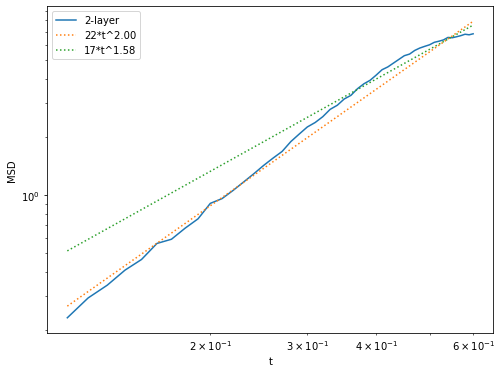

In [11]:
si = 10
sf = 60

fig = plt.figure(figsize=(8, 6))
linewidth = 1.5
linestyle = '-'

plt.plot(t[si:sf], qasm[1,si:sf], linewidth=linewidth, linestyle=linestyle, label=f'{2}-layer')

consts = [22, 17]
powers = [2, np.log2(3)]
fitting(t, consts, powers, si, steps, linewidth=linewidth, linestyle=':')

plt.legend()
plt.xlabel("t")
plt.ylabel("MSD")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [5]:
order = 2

In [6]:
folder = 'ex'
network = 'tri'
length = 2**order-1
ws = WalkSystem(folder, network, length=length)
tri = ws.read_msd_list()

In [7]:
folder = 'ex'
network = 'dsg'
ws = WalkSystem(folder, network, order=order)
dsg = ws.read_msd_list()

In [8]:
folder = 'sim'
network = 'dsg'
sys = 'qasm'
layers = [1,2,3,4,5,10]
ws = WalkSystem(folder, network, sys=sys)
qasm = ws.read_all_msd(layers=layers)

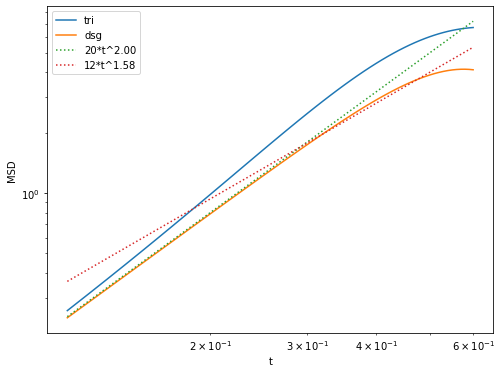

In [9]:
si = 10
sf = 60

fig = plt.figure(figsize=(8, 6))
linewidth = 1.5
linestyle = '-'
selected_layers = [1,2,3,4,5]

plt.plot(t[si:sf], tri[si:sf], linewidth=linewidth, linestyle=linestyle, label='tri')
plt.plot(t[si:sf], dsg[si:sf], linewidth=linewidth, linestyle=linestyle, label='dsg')
# for ly in selected_layers:
#     i = layer_dict[ly]
#     plt.plot(t[si:sf], qasm[i, si:sf], linewidth=linewidth, linestyle=linestyle, label=f'{ly}-layer')

consts = [20, 12]
powers = [2, 1.585]
fitting(t, consts, powers, si, steps, linewidth=linewidth, linestyle=':')

plt.legend()
plt.xlabel("t")
plt.ylabel("MSD")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [5]:
folder = 'ex'

In [6]:
network = 'tri'
lengths = [3,4,7,8,15,16]
ws = WalkSystem(folder, network)
tri = ws.read_all_msd(length=lengths)

In [7]:
network = 'sg'
orders = [2,3,4]
ws = WalkSystem(folder, network)
sg = ws.read_all_msd(order=orders)

In [8]:
network = 'dsg'
orders = [2,3,4]
ws = WalkSystem(folder, network)
dsg = ws.read_all_msd(order=orders)

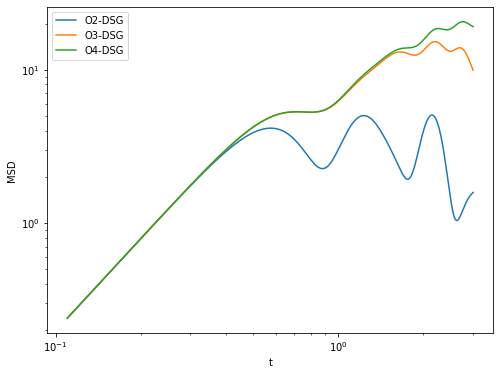

In [9]:
si = 10
sf = 300

fig = plt.figure(figsize=(8, 6))
linewidth = 1.5
linestyle = '-'
selected_orders = [2,3,4]

# for order in selected_orders:
#     length = 2**order
#     i = order_dict[order]
#     j = length_dict[length]
#     plt.plot(t[si:sf], tri[j, si:sf], linewidth=linewidth, linestyle=linestyle, label=f'L{length}-Tri')
#     plt.plot(t[si:sf], sg[i, si:sf], linewidth=linewidth, linestyle=linestyle, label=f'O{order}-SG')

for order in selected_orders:
    length = 2**order-1
    i = order_dict[order]
    j = length_dict[length]
#     plt.plot(t[si:sf], tri[j, si:sf], linewidth=linewidth, linestyle=linestyle, label=f'L{length}-Tri')
    plt.plot(t[si:sf], dsg[i, si:sf], linewidth=linewidth, linestyle=linestyle, label=f'O{order}-DSG')

# const_list = [50, 16]
# power_list = [2.4, 1.585]
# fitting(t, const_list, power_list, si, steps, linewidth=linewidth, linestyle=':')

plt.legend()
plt.xlabel("t")
plt.ylabel("MSD")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [5]:
import numpy as np

def validity(counts_list: list, steps: int) -> np.ndarray:
    
    displacement_dict = {"000000001":0, "000000010":1, "000000100":1, 
                     "000001000":9, "000010000":7, "000100000":4,
                     "001000000":9, "010000000":4, "100000000":7}
    
    valid_counts_list = []
    
    for i in range(steps):
        valid_counts = 0
        for bit, count in counts_list[i].items():
            valid_counts += (displacement_dict.get(bit, -1) > -1) * count
        valid_counts_list.append(valid_counts)
    
    return np.array(valid_counts_list, dtype=np.float64)

In [6]:
import numpy as np

def inrprod(qpu_counts_list: list, sim_counts_list: list, steps: int, shots: int=4000) -> np.ndarray:
    
    inrprod_list = []
    valid_counts = validity(qpu_counts_list, steps)
    
    for i in range(steps):
        _inrprod = 0.
        for bit, count in sim_counts_list[i].items():
            temp_sim = np.sqrt(count/shots)
            temp_qpu = np.sqrt(dict(qpu_counts_list[i].items()).get(bit, 0)/valid_counts[i])
            _inrprod += temp_sim*temp_qpu
        inrprod_list.append(_inrprod)
    
    return np.array(inrprod_list)

In [7]:
layers = 2
shots = 4000

folder = 'sim'
network = 'dsg'
sys = 'qasm'
ws = WalkSystem(folder, network, sys=sys, layers=layers)
sim_counts_list = ws.read_counts_list()

folder = 'qpu'
network = 'dsg'
ws = WalkSystem(folder, network, layers=layers)
sys_list = ['montreal','mumbai','auckland','hanoi']
qpu_counts_list = ws.read_all_counts(sys=sys_list)

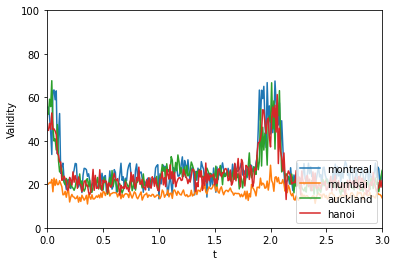

In [8]:
si = 0
sf = 300

for i, sys in enumerate(sys_list):
    valid_percentage = validity(qpu_counts_list[i], steps=ws._steps)*100/shots
    plt.plot(t[si:sf], valid_percentage[si:sf], label=f'{sys}')

plt.legend(loc='lower right')
plt.xlim([si*dt,sf*dt])
plt.ylim([0, 100])
plt.xlabel("t")
plt.ylabel("Validity")
plt.show()

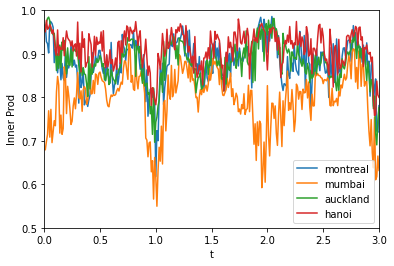

In [9]:
si = 0
sf = 300

for i, sys in enumerate(sys_list):
    inrprod_list = inrprod(qpu_counts_list[i], sim_counts_list, steps=ws._steps, shots=shots)
    plt.plot(t[si:sf], inrprod_list[si:sf], label=f'{sys}')

plt.legend(loc='lower right')
plt.xlim([si*dt,sf*dt])
plt.ylim([0.5, 1])
plt.xlabel("t")
plt.ylabel("Inner Prod")
plt.show()

In [5]:
order = 2

In [6]:
folder = 'ex'
network = 'dsg'
ws = WalkSystem(folder, network, order=order)
dsg = ws.read_msd_list()

In [7]:
folder = 'sim'
network = 'dsg'
sys = 'qasm'
layers = [1,2,3,4,5,10]
ws = WalkSystem(folder, network, sys=sys)
qasm = ws.read_all_msd(layers=layers)

In [8]:
folder = 'qpu'
network = 'dsg'
sys = 'hanoi'
layers = [1,2]
ws = WalkSystem(folder, network, sys=sys)
qpu = ws.read_all_msd(layers=layers)

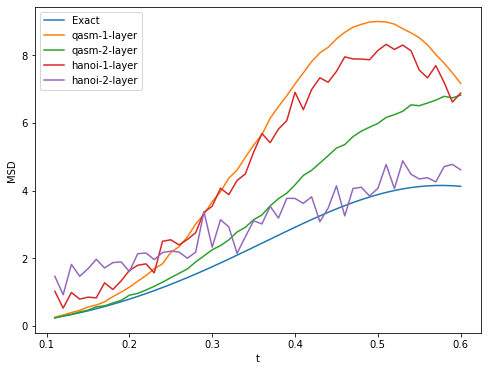

In [9]:
si = 10
sf = 60

fig = plt.figure(figsize=(8, 6))
linewidth = 1.5
linestyle = '-'
selected_layers = [1, 2]

plt.plot(t[si:sf], dsg[si:sf], linewidth=linewidth, linestyle=linestyle, label='Exact')
for ly in selected_layers:
    i = layer_dict[ly]
    plt.plot(t[si:sf], qasm[i,si:sf], linewidth=linewidth, linestyle=linestyle, label=f'qasm-{ly}-layer')
for ly in selected_layers:
    i = layer_dict[ly]
    plt.plot(t[si:sf], qpu[i,si:sf], linewidth=linewidth, linestyle=linestyle, label=f'{sys}-{ly}-layer')

plt.legend()
plt.xlabel("t")
plt.ylabel("MSD")
# plt.xscale("log")
# plt.yscale("log")
plt.show()

In [5]:
folder = 'ex'
network = 'tri'
lengths = [3,4,7,8,15,16]
ws = WalkSystem(folder, network)
tri = ws.read_all_msd(length=lengths)

In [6]:
folder = 'ex'
network = 'sg'
orders = [2,3,4]
ws = WalkSystem(folder, network)
sg = ws.read_all_msd(order=orders)

In [7]:
folder = 'ex'
network = 'dsg'
orders = [2,3,4]
ws = WalkSystem(folder, network)
dsg = ws.read_all_msd(order=orders)

In [8]:
folder = 'sim'
network = 'dsg'
sys = 'qasm'
layers = [1,2,3,4,5,10]
ws = WalkSystem(folder, network, sys=sys)
qasm = ws.read_all_msd(layers=layers)

In [9]:
folder = 'sim'
network = 'dsg'
sys = 'qasm'
layers = [1,2,3,4,5,10]
ws = WalkSystem(folder, network, sys=sys, logsize=True)
qasm_log = ws.read_all_msd(layers=layers)

In [10]:
folder = 'qpu'
network = 'dsg'
sys = 'hanoi'
layers = [1,2]
ws = WalkSystem(folder, network, sys=sys)
qpu = ws.read_all_msd(layers=layers)

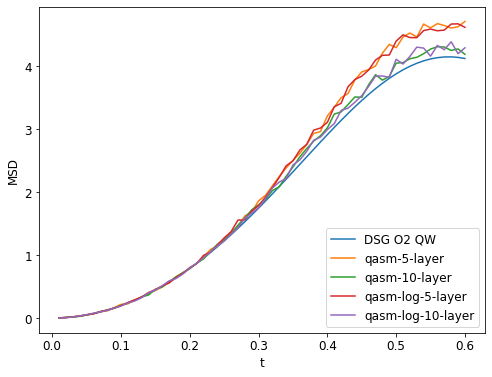

In [11]:
si = 0
sf = 60

plt.rc('font', size=12)
fig = plt.figure(figsize=(8, 6))
linewidth = 1.5
linestyle = '-'
selected_orders = [2]
selected_lengths = [3]
selected_layers = [5, 10]

# for length in selected_lengths:
#     i = length_dict[length]
#     plt.plot(t[si:sf], tri[i,si:sf], linewidth=linewidth, linestyle=linestyle, label=f'Tri L{length} QW')

# for order in selected_orders:
#     i = order_dict[order]
#     plt.plot(t[si:sf], sg[i,si:sf], linewidth=linewidth, linestyle=linestyle, label=f'SG O{order} QW')

for order in selected_orders:
    i = order_dict[order]
    plt.plot(t[si:sf], dsg[i,si:sf], linewidth=linewidth, linestyle=linestyle, label=f'DSG O{order} QW')

for ly in selected_layers:
    i = layer_dict[ly]
    plt.plot(t[si:sf], qasm[i, si:sf], linewidth=linewidth, linestyle=linestyle, label=f'qasm-{ly}-layer')

for ly in selected_layers:
    i = layer_dict[ly]
    plt.plot(t[si:sf], qasm_log[i, si:sf], linewidth=linewidth, linestyle=linestyle, label=f'qasm-log-{ly}-layer')

# for ly in selected_layers:
#     i = layer_dict[ly]
#     plt.plot(t[si:sf], qpu[i, si:sf], linewidth=linewidth, linestyle=linestyle, label=f'{sys}-{ly}-layer')

plt.legend(loc='lower right')
plt.xlabel("t")
plt.ylabel("MSD")
# plt.xscale("log")
# plt.yscale("log")

# plt.xlim([0, 0.6])
# plt.ylim([0, 10])
# plt.savefig(f'images/comp_qasm-mumbai_{steps*dt:.1f}s_{1}ly_msd_plot.svg', format='svg')

plt.show()

In [18]:
order = 2
layers = 2

In [6]:
import numpy as np

def transform_counts_list(counts_list):
    
    place_dict = {"000000001":0, "000000010":1, "000000100":2, 
                  "000001000":3, "000010000":4, "000100000":5, 
                  "001000000":6, "010000000":7, "100000000":8}
    
    trans_list = []
    
    for i, counts in enumerate(counts_list):
        trans_counts = np.zeros(9)
        for bits, number in counts.items():
            if place_dict.get(bits, -1) > -1:
                trans_counts[place_dict.get(bits)] = number
        trans_list.append(trans_counts/trans_counts.sum())
    
    return np.array(trans_list)

In [7]:
folder = 'qpu'
network = 'dsg'
sys = 'hanoi'
ws = WalkSystem(folder, network, sys=sys, layers=layers)
counts_list = ws.read_counts_list()
counts_list = transform_counts_list(counts_list)

In [8]:
import numpy as np

def DSG_Hamiltonian(order: int=2, gamma: float=1.) -> np.ndarray:
    
    size = 3**order
    A = np.zeros((size, size))
    
    for i in [n+1 for n in range(order)]:
        for j in range(int(size/(3**i))):
            a1 = np.floor((j*9 + 0*3 + 1) * 3**(i-2)).astype(int)
            a2 = np.floor((j*9 + 1*3 + 2) * 3**(i-2)).astype(int)
            b1 = np.floor((j*9 + 1*3 + 1) * 3**(i-2)).astype(int)
            b2 = np.floor((j*9 + 2*3 + 2) * 3**(i-2)).astype(int)
            c1 = np.floor((j*9 + 2*3 + 1) * 3**(i-2)).astype(int)
            c2 = np.floor((j*9 + 0*3 + 2) * 3**(i-2)).astype(int)
            A[a1, a2] = 1
            A[a2, a1] = 1
            A[b1, b2] = 1
            A[b2, b1] = 1
            A[c1, c2] = 1
            A[c2, c1] = 1
    
    for i in range(size):
        A[i, i] = -A.sum(axis=1)[i]
    
    return -gamma*A

In [9]:
from matplotlib.colors import LinearSegmentedColormap

cdict = {'red':   ((0.00, 0.00, 0.00), 
                   (0.20, 0.95, 0.95),
                   (0.40, 0.95, 0.95),
                   (0.60, 0.95, 0.95),
                   (0.80, 0.95, 0.95),
                   (1.00, 0.00, 0.00)),

         'green': ((0.00, 0.00, 0.00), 
                   (0.20, 0.00, 0.00),
                   (0.40, 0.50, 0.50),
                   (0.60, 0.95, 0.95),
                   (0.80, 0.95, 0.95),
                   (1.00, 0.00, 0.00)),

         'blue':  ((0.00, 0.00, 0.00), 
                   (0.20, 0.00, 0.00),
                   (0.40, 0.30, 0.30),
                   (0.60, 0.50, 0.50),
                   (0.80, 0.95, 0.95),
                   (1.00, 0.95, 0.95))
          }

cmap = LinearSegmentedColormap('star', cdict)

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_distribution(G, pos, node_size=100, node_color="#1f78b4", alpha=1., mapper=None, 
                      cmap=None, vmin=None, vmax=None, ax=None):
    
    if ax is None:
        ax = plt.gca()
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, alpha=alpha, 
                                   cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
    edges = nx.draw_networkx_edges(G, pos, ax=ax)
    cb = plt.colorbar(mapper, ax=ax, extend='min')
    cb.ax.tick_params(labelsize=12)
    ax.axis('off')
    
    return nodes

In [11]:
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

G = nx.from_numpy_array(abs(DSG_Hamiltonian(order, 1)))
G.remove_edges_from(nx.selfloop_edges(G))
pos = nx.kamada_kawai_layout(G)

# vmin = 10**(1-order)
vmin = .5*10**(1-order)
vmax = 1.
mapper = ScalarMappable(norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)

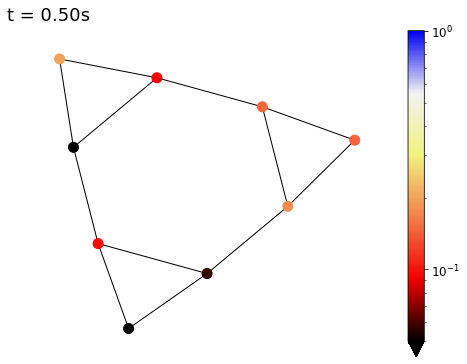

In [12]:
choose = 49

dpi = 72
fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

node_color = counts_list[choose]
time_template = 't = %.2fs'

nodes = draw_distribution(G, pos, ax=ax, node_color=mapper.to_rgba(node_color), mapper=mapper)
time_text = ax.text(-1, 1, time_template % ((choose+1)*dt), fontsize=18)

plt.show()

In [13]:
from matplotlib import animation

dpi = 300
steps = 60
playtime = 15
interval = int(playtime*1000/steps)
fps = int(steps/playtime)
fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

node_color = counts_list[0]
time_template = 't = %.2fs'

nodes = draw_distribution(G, pos, ax=ax, node_color=mapper.to_rgba(node_color), mapper=mapper)
time_text = ax.text(-1, 1, time_template % 0., fontsize=18)

def animate(i):
    global nodes, time_text
    nodes.remove()
    time_text.remove()
    node_color = counts_list[i]
    nodes = nx.draw_networkx_nodes(G, pos, node_size=100, node_color=mapper.to_rgba(node_color), alpha=1.)
    time_text = ax.text(-1, 1, time_template % ((i+1)*dt), fontsize=18)
    return 0

ani = animation.FuncAnimation(fig, animate, frames=steps, interval=interval)

def progress_callback(i, n):
    print(f'Saving frame {i} of {n}', end='\r')
    return 0

writer = animation.writers['ffmpeg'](fps=fps)
path = f'videos/{ws.sys}_{ws.network}_{ws.walk}_{steps*dt:.1f}s_{layers:d}ly_animation.mp4'
ani.save(path, writer=writer, dpi=dpi, progress_callback=progress_callback)
del ani
plt.close(fig)
print(f'Saving frame {steps} of {steps} complete!')

Saving frame 60 of 60 complete!


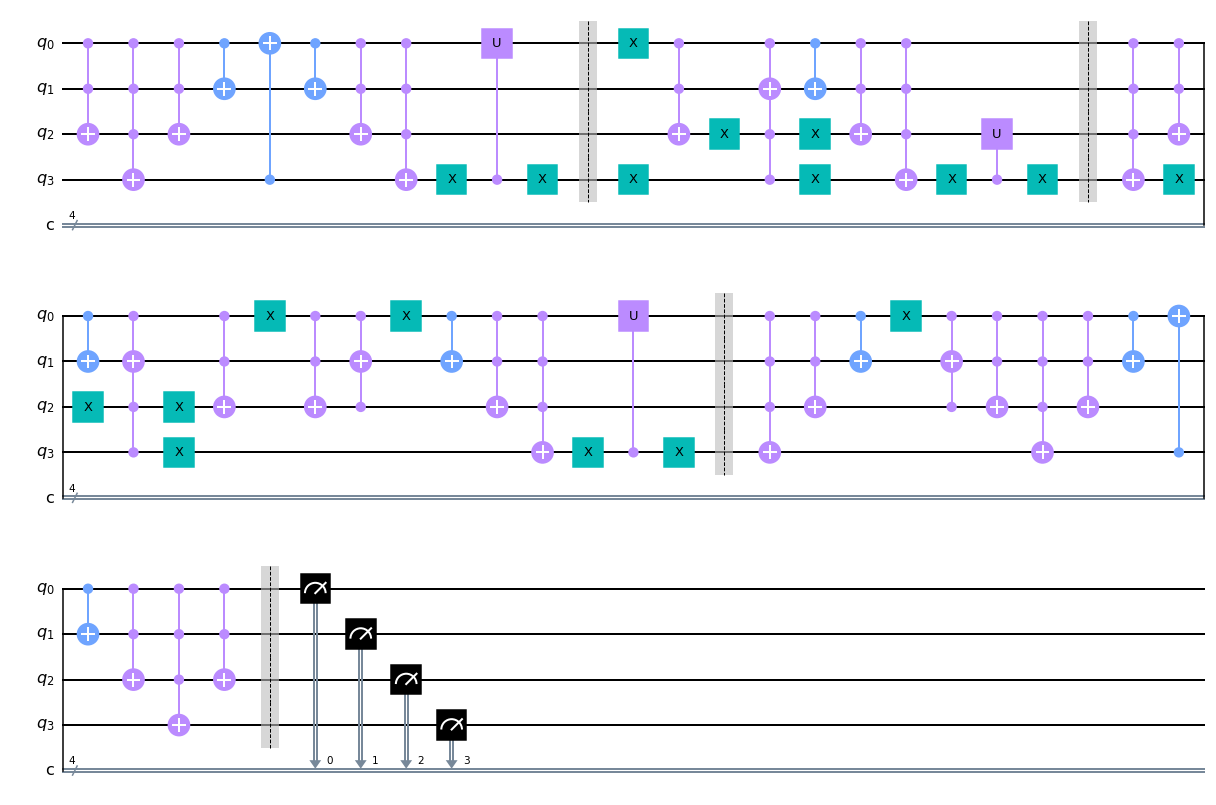

In [12]:
from quantum_walk_simulation import *
staggered_dsg_circuit_log3t(2, .5, 1, barrier=True).draw('mpl')

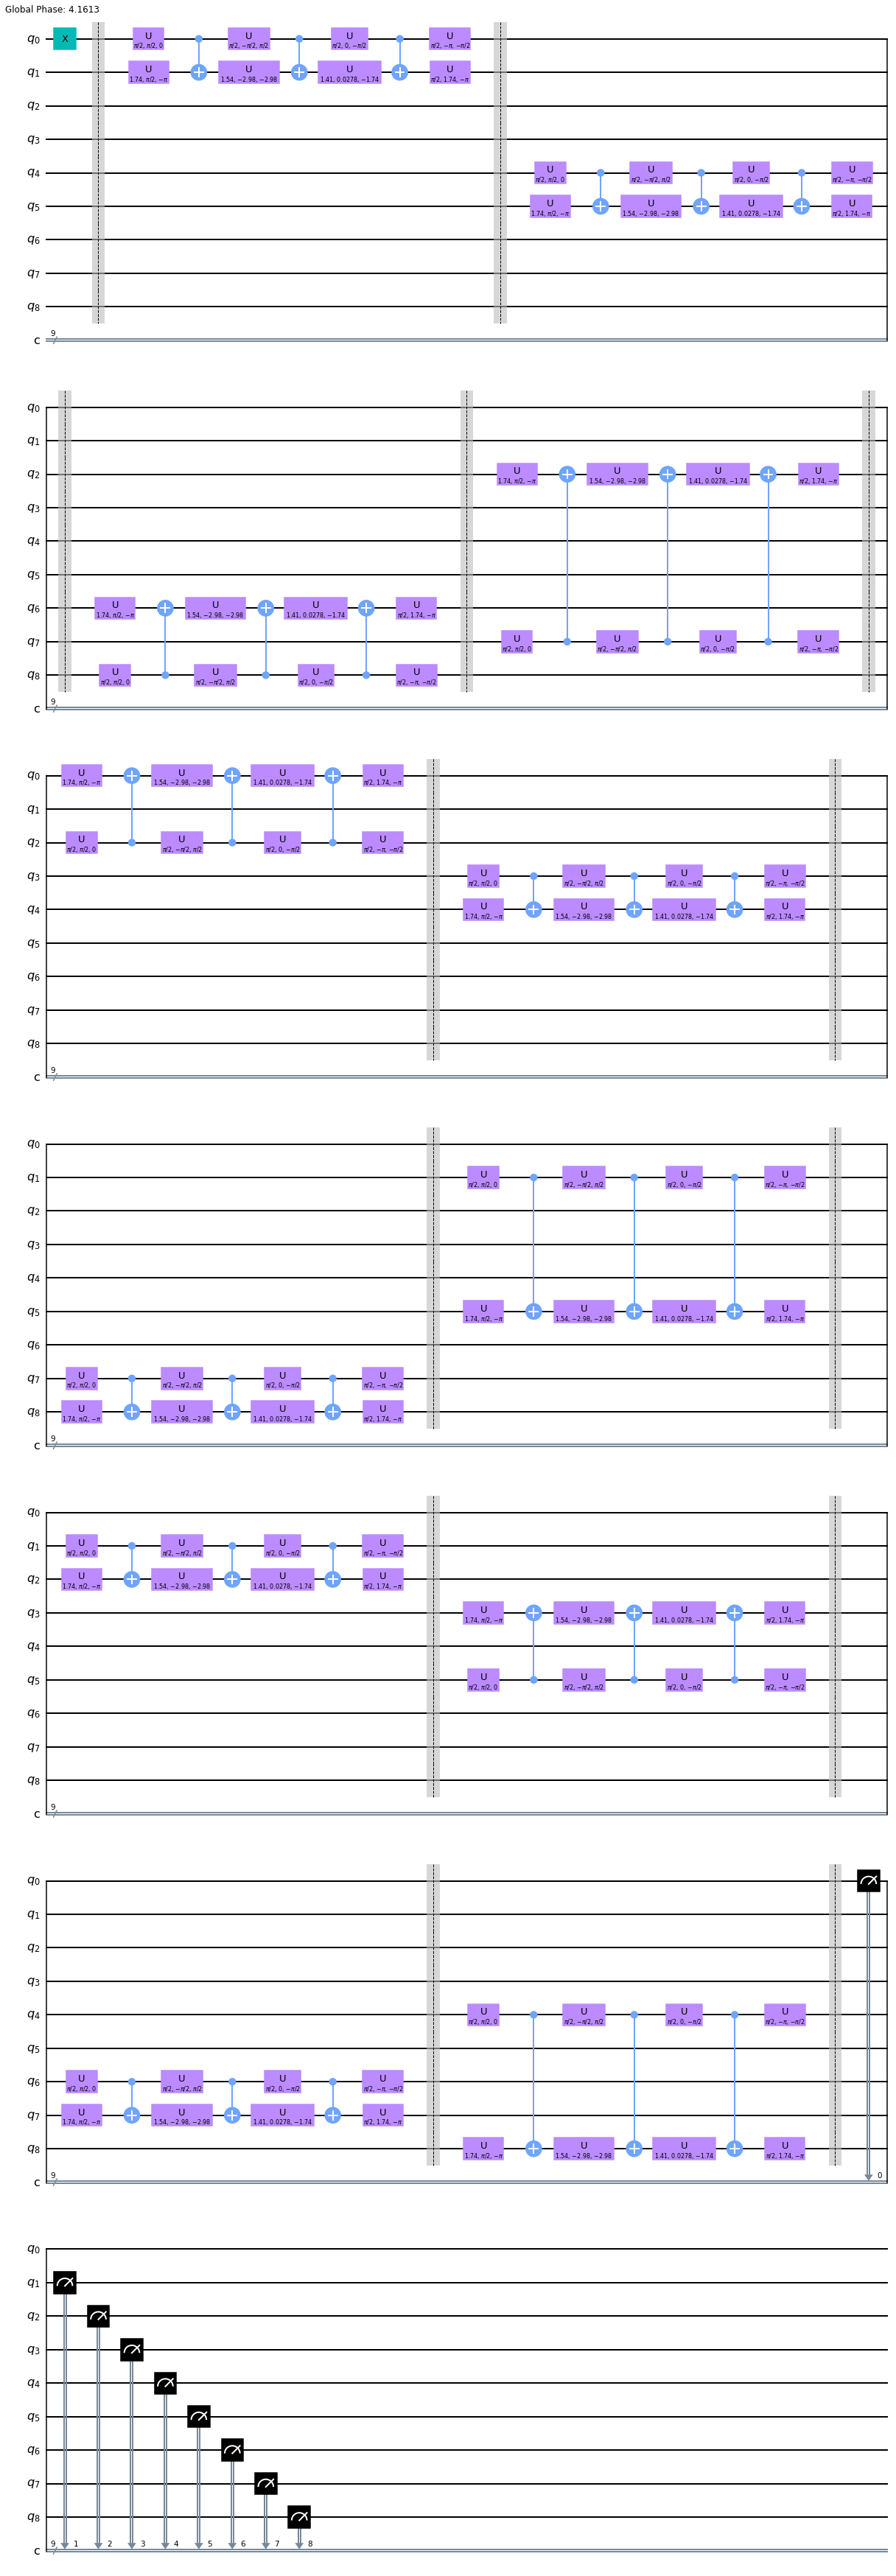

In [13]:
staggered_dsg_circuit_3t(2, .5, 1, decompose=True, linear_operation=True).draw('mpl')